In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam

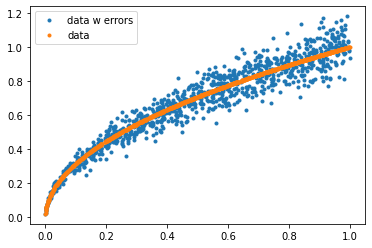

tensor(0.0461) 0.49082001826867744


In [14]:
# data

def addGaussianNoise(val):
    sigma = val
    distro = np.random.normal(val, sigma, size=128)
    return np.mean(distro), np.var(distro)


x = np.random.rand(1024)
y_clean = x**0.5
y_dirty, y_dirty_err = np.vectorize(addGaussianNoise)(x**0.5)
plt.plot(x, y_dirty, '.', label='data w errors')
plt.plot(x, y_clean, '.', label='data')
plt.legend()
plt.show()

X = torch.from_numpy(x.astype(np.float32)).unsqueeze(-1)
Y_clean = torch.from_numpy(y_clean.astype(np.float32)).unsqueeze(-1)
Y_dirty = torch.from_numpy(y_dirty.astype(np.float32)).unsqueeze(-1)

print(torch.mean(np.abs(Y_clean - Y_dirty)), np.mean(y_dirty_err))

In [20]:
# models

model1 = nn.Sequential(
        nn.Linear(1, 64),
        nn.ELU(),
        nn.Linear(64, 64),
        nn.ELU(),
        nn.Linear(64, 1)
    )

model2 = nn.Sequential(
        nn.Linear(1, 64),
        nn.ELU(),
        nn.Linear(64, 64),
        nn.ELU(),
        nn.Linear(64, 1)
    )

loss_function = nn.MSELoss()
n_epochs = 1000
batch_size = 32
n_batches = 1024 // 32

optimizer1 = Adam(model1.parameters(), lr=1e-4)
optimizer2 = Adam(model2.parameters(), lr=1e-4)

In [ ]:
# training

loss, loss_w_noise = [], []
for e in range(n_epochs):
    for b in range(n_batches):
        start = b * batch_size
        end = (b + 1) * batch_size
        inp = X[start:end]
        cleans = Y_clean[start:end]
        dirtys = Y_dirty[start:end]
        
        preds1 = model1(inp)
        loss1 = loss_function(preds1, cleans)
        loss1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

        preds2 = model2(inp)
        loss2 = loss_function(preds2, dirtys)
        loss2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    if e % 10 == 0:
        loss.append(loss1)
        loss_w_noise.append(loss2)
        print(e, loss1.detach().numpy(), loss2.detach().numpy())
plt.semilogy(loss, label='No noise')
plt.semilogy(loss_w_noise, label='With noise')
plt.legend()
plt.show()

0 0.118952274 0.045082483
10 0.001922949 0.0054129804
20 0.0018337046 0.0051945117
30 0.0016876562 0.0049816915
40 0.0015126097 0.0047794753
50 0.0013138246 0.004623841
60 0.0010953428 0.004484506
70 0.0008649389 0.004349589
80 0.00064806035 0.0042210873
90 0.0004805358 0.0041049463
100 0.0003775803 0.0040089437
110 0.0003298265 0.0039378945
120 0.00030954214 0.0038930478
130 0.00029480623 0.0038725578
140 0.00027927101 0.0038717499
150 0.0002639444 0.0038835318
160 0.0002493919 0.0039009103
170 0.00023228972 0.0039190687
180 0.00021234274 0.0039354246
190 0.00019082057 0.0039489744
200 0.00016808072 0.003959635
210 0.00014435171 0.0039677937
220 0.00012031448 0.0039739367
230 9.786603e-05 0.003978573
240 7.884101e-05 0.0039821453
250 6.367894e-05 0.003984966
260 5.183678e-05 0.003987248
270 4.235599e-05 0.0039891507
280 3.4798573e-05 0.003990771
290 2.897006e-05 0.003992168
300 2.4614004e-05 0.0039934046
310 2.143466e-05 0.0039945077
320 1.9105813e-05 0.0039954954
330 1.7343871e-05 0.

clean MAE: 0.0017178364
clean RMSE: 0.003234033
dirty MAE: 0.049949452
dirty RMSE: 0.066740155


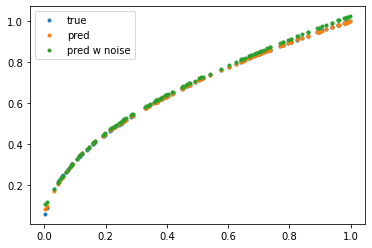

In [17]:
val_X = torch.rand(128).unsqueeze(-1)
val_Y = (val_X**0.5)
val_Y_dirty = torch.from_numpy(np.vectorize(addGaussianNoise)(val_X.detach().numpy()**0.5)[0].astype(np.float32))
test1 = model1(val_X)
test2 = model2(val_X)


val_Y = val_Y.detach().numpy()
val_Y_dirty = val_Y_dirty.detach().numpy()
test1 = test1.detach().numpy()
test2 = test2.detach().numpy()
print('clean MAE:', np.mean(np.abs(test1 - val_Y)))
print('clean RMSE:', np.sqrt(np.mean((test1 - val_Y)**2)))
print('dirty MAE:', np.mean(np.abs(test2 - val_Y_dirty)))
print('dirty RMSE:', np.sqrt(np.mean((test2 - val_Y_dirty)**2)))


plt.plot(val_X, val_Y, '.', label='true')
plt.plot(val_X, test1, '.', label='pred')
plt.plot(val_X, test2, '.', label='pred w noise')
plt.legend()
plt.show()